In [2]:
import os
import cv2
import copy
import torch
import numpy as np
import open3d as o3d
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_scan,
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [36]:
def plot_images(images, max_cols=5, titles=None, per_img_width=3, cmap=None, cbar_cols=None, cbar_kw=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n = len(images)
    h_to_w = images[0].shape[0] / images[0].shape[1]
    cols = max(1, min(max_cols, n))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*per_img_width, rows*per_img_width*h_to_w), squeeze=False)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i >= n: ax.axis('off'); continue
        img = images[i]
        arr = plt.imread(img) if isinstance(img, (str, os.PathLike)) else np.asarray(img)
        im = ax.imshow(arr, cmap=(cmap if arr.ndim == 2 else None))
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        if titles and i < len(titles) and titles[i]: ax.set_title(titles[i], fontsize=9, pad=2)
        if arr.ndim == 2 and cbar_cols and (i % cols) in cbar_cols:
            cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.02)
            fig.colorbar(im, cax=cax, **(cbar_kw or {}))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    return fig, axes[:n]


## Single Object Test

In [3]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    # ('table', 'table.obj'),
    # ('power-drill', 'power-drill.obj'),
    # ('bleach', 'bleach.obj'),
    # ('pitcher', 'pitcher.obj'),
    # ('mug', 'mug.obj'),
    # ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

Getting the mustard-bottle


In [27]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 360
height: int = 240
fov: float = 70.0
k: float = 5
max_normal_angle_deg = None
N = 1

scans = []
ccs = []
a = 45
c = 60
rs = (0.35, 1)
ls = (50, 80)
for i in range(360//c):
    r = rs[0] if i%2==0 else rs[1]
    l = ls[0] if i%2==0 else ls[1]
    ccs.append(cam_offset + polar2cartesian(r=r, lat=l, long=a+i*c))
for cc in ccs:
    object_meshes, object_weights = virtual_mesh_scan(
        gt_mesh_list,
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =1e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =2e-4,      # constant perlin noise term
        linear_perlin_sigma     =1e-3,      # linear depth term
        quadrt_perlin_sigma     =1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =1e-4,      # std of per-segment scale noise
        rot_std                 =1e-4,      # std of global rotation noise
        trn_std                 =1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =False,
    )
    for mesh in object_meshes:
        mesh.compute_vertex_normals()
    scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])

all_meshes = [m for scan in scans for (m, _) in scan]

dcols = distinct_colours(len(all_meshes), s=0.8)
col_meshes = []
for i,mesh in enumerate(all_meshes):
    m = copy.deepcopy(mesh)
    m.paint_uniform_color(dcols[i])
    col_meshes.append(m)

o3d.visualization.draw_geometries(col_meshes)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


#### Fusion with uncertainty

In [28]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t in range(1,len(scans)):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in range(N):
        print(f't={t}, obj_id={obj_id}')
        fused_obj_mesh, fused_obj_weights = fuse_meshes(
            mesh1           = fused_scan[obj_id][0],
            weights1        = fused_scan[obj_id][1],
            mesh2           = scans[t][obj_id][0],
            weights2        = scans[t][obj_id][1],
            h_alpha         = 3,
            r_alpha         = 3,
            nrm_shift_iters = 2,
            nrm_smth_iters  = 1,
            sigma_theta = 0.1,
            normal_diff_thresh = 20.0,
            tau_max = None,
            shift_all = False,
            ball_radius_percentiles = [10, 50, 90],
            bilateral_weight_update = False,
        )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

fused_mesh_result = [obj[0] for obj in fused_scan]
o3d.visualization.draw_geometries(fused_mesh_result)

t=1, obj_id=0
t=2, obj_id=0
t=3, obj_id=0
t=4, obj_id=0
t=5, obj_id=0


#### Fusion without uncertainty

In [29]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t in range(1,len(scans)):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in range(N):
        print(f't={t}, obj_id={obj_id}')
        fused_obj_mesh, fused_obj_weights = fuse_meshes(
            mesh1           = fused_scan[obj_id][0],
            weights1        = None,
            mesh2           = scans[t][obj_id][0],
            weights2        = None,
            h_alpha         = 3,
            r_alpha         = 3,
            nrm_shift_iters = 2,
            nrm_smth_iters  = 1,
            sigma_theta = 0.1,
            normal_diff_thresh = 20.0,
            tau_max = None,
            shift_all = False,
            ball_radius_percentiles = [10, 50, 90],
            bilateral_weight_update = False,
        )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

fused_mesh_result = [obj[0] for obj in fused_scan]
o3d.visualization.draw_geometries(fused_mesh_result)

t=1, obj_id=0
t=2, obj_id=0
t=3, obj_id=0
t=4, obj_id=0
t=5, obj_id=0


## Scene Test

In [3]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug
Getting the extra-large-clamp


In [49]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 360
height: int = 240
fov: float = 70.0
k: float = 3
max_normal_angle_deg = None
N = 1

scans = []
depth_images = []
ccs = []
a = 45
c = int(360/10)
rs = (0.5, 0.5)
ls = (50, 80)
for i in range(360//c):
    r = rs[0] if i%2==0 else rs[1]
    l = ls[0] if i%2==0 else ls[1]
    ccs.append(cam_offset + polar2cartesian(r=r, lat=l, long=a+i*c))
for cc in ccs:
    object_meshes, object_weights, depth_info = virtual_mesh_scan(
        gt_mesh_list,
        cc,
        look_at,
        k=k,
        max_normal_angle_deg=max_normal_angle_deg,
        width_px=width,
        height_px=height,
        fov=fov,
        constant_uncertainty    =2e-4,
        linear_uncertainty      =2e-3,      # rate of uncertainty increase with depth
        quadrt_uncertainty      =1e-4,      # quadratic uncertainty coefficient
        constant_perlin_sigma   =2e-4,      # constant perlin noise term
        linear_perlin_sigma     =2e-3,      # linear depth term
        quadrt_perlin_sigma     =1e-4,      # quadratic depth term
        perlin_octaves          =3,
        seg_scale_std           =1e-4,      # std of per-segment scale noise
        rot_std                 =1e-4,      # std of global rotation noise
        trn_std                 =1e-3,      # std of global translation noise
        grazing_lambda          =1.0,       # sigma multiplier at grazing angles; 0 disables
        seed                    =None,
        include_depth_image     =True,
    )
    for mesh in object_meshes:
        mesh.compute_vertex_normals()
    depth_images.append(depth_info)
    scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])

all_meshes = [m for scan in scans for (m, w) in scan]

dcols = distinct_colours(len(all_meshes), s=0.8)
col_meshes = []
for i,mesh in enumerate(all_meshes):
    m = copy.deepcopy(mesh)
    m.paint_uniform_color(dcols[i])
    col_meshes.append(m)

o3d.visualization.draw_geometries(col_meshes)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


(<Figure size 1500x400 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

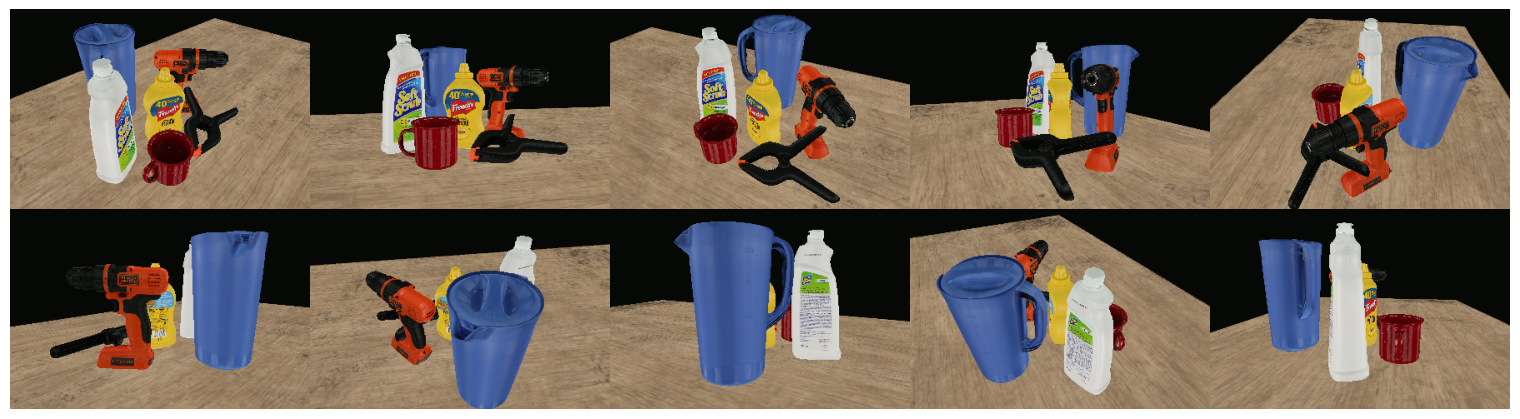

In [50]:
all_rgb = [np.flip(d['rgb'], axis=[0,1]) for d in depth_images]
plot_images(all_rgb,max_cols=5)

#### Fusion with uncertainty

In [51]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, fused_obj_weights = fuse_meshes(
                mesh1=mesh1, weights1=weights1,
                mesh2=mesh2, weights2=weights2,
                h_alpha             = 3,
                r_alpha             = 3,
                nrm_shift_iters     = 2,
                nrm_smth_iters      = 1,
                sigma_theta         = 0.1,
                normal_diff_thresh  = 20.0,
                tau_max = None,
                shift_all = False,
                ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                bilateral_weight_update = False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

fused_mesh_result_unc = [obj[0] for obj in fused_scan]
o3d.visualization.draw_geometries(fused_mesh_result_unc)

Scan:   0%|          | 0/9 [00:00<?, ?scan/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 5 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 6 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 7 obj 2 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

#### Fusion without uncertainty

In [52]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t, scan in enumerate(tqdm(scans[1:], desc="Scan", unit="scan"), start=1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in tqdm(range(N), desc="Object", unit="obj", position=1, leave=False):
        mesh1, weights1 = fused_scan[obj_id]
        mesh2, weights2 = scan[obj_id]

        if len(np.asarray(mesh1.vertices)) == 0:
            tqdm.write(f"Scan {t-1} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh2, weights2
        elif len(np.asarray(mesh2.vertices)) == 0:
            tqdm.write(f"Scan {t} obj {obj_id} is empty")
            fused_obj_mesh, fused_obj_weights = mesh1, weights1
        else:
            fused_obj_mesh, fused_obj_weights = fuse_meshes(
                mesh1=mesh1, weights1=None,
                mesh2=mesh2, weights2=None,
                h_alpha             = 3,
                r_alpha             = 3,
                nrm_shift_iters     = 2,
                nrm_smth_iters      = 1,
                sigma_theta         = 0.1,
                normal_diff_thresh  = 20.0,
                tau_max = None,
                shift_all = False,
                ball_radius_percentiles = [1,5,15,30,50,70,85,95,99],
                bilateral_weight_update = False,
            )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

fused_mesh_result_nounc = [obj[0] for obj in fused_scan]
o3d.visualization.draw_geometries(fused_mesh_result_nounc)

Scan:   0%|          | 0/9 [00:00<?, ?scan/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 5 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 6 obj 5 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Scan 7 obj 2 is empty


Object:   0%|          | 0/7 [00:00<?, ?obj/s]

Object:   0%|          | 0/7 [00:00<?, ?obj/s]

In [63]:
o3d.visualization.draw_geometries(fused_mesh_result_unc)

In [64]:
o3d.visualization.draw_geometries(fused_mesh_result_nounc)